In [2]:
# Import
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import collect_list, collect_set # collect_set return set of values (no duplicate)
from pyspark.sql import functions as F
from itertools import combinations
from pyspark.sql.functions import col, udf, explode
from pyspark.sql.types import ArrayType, StringType
import findspark
findspark.init()

In [3]:
# Create SparkSession
spark = SparkSession.builder\
    .master("local[*]") \
    .appName("Map Reduce with Pyspark") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()

25/01/02 18:18:04 WARN Utils: Your hostname, helium resolves to a loopback address: 127.0.1.1; using 10.0.106.13 instead (on interface enp6s0)
25/01/02 18:18:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/02 18:18:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [38]:
products_path = "../dataset_sales/products.csv"
products = spark.read.csv(products_path, header=True)
products.distinct().count()

25/01/02 19:39:17 ERROR Executor: Exception in task 0.0 in stage 47.0 (TID 456)
org.apache.spark.SparkFileNotFoundException: /home/karolina/Big_data/dataset_sales/products.csv (Permission denied)
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:781)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:222)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:282)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:131)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.Ge

Py4JJavaError: An error occurred while calling o154.csv.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 47.0 failed 1 times, most recent failure: Lost task 0.0 in stage 47.0 (TID 456) (10.0.106.13 executor driver): org.apache.spark.SparkFileNotFoundException: /home/karolina/Big_data/dataset_sales/products.csv (Permission denied)
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:781)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:222)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:282)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:131)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.execution.datasources.csv.TextInputCSVDataSource$.infer(CSVDataSource.scala:111)
	at org.apache.spark.sql.execution.datasources.csv.CSVDataSource.inferSchema(CSVDataSource.scala:64)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.inferSchema(CSVFileFormat.scala:62)
	at org.apache.spark.sql.execution.datasources.DataSource.$anonfun$getOrInferFileFormatSchema$11(DataSource.scala:208)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:205)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:407)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:538)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkFileNotFoundException: /home/karolina/Big_data/dataset_sales/products.csv (Permission denied)
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:781)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:222)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:282)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:131)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [4]:
data_path = "../dataset_sales/joined_all_data.csv"
df = spark.read.csv(data_path, header=True)


In [5]:
df.show(12)

+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id|               aisle|department|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|       2|     33120|                1|        1|  Organic Egg Whites|      86|           16|                eggs|dairy eggs| 202279|   prior|           3|        5|                9|                   8.0|
|       2|     28985|                2|        1|Michigan Organic ...|      83|            4|    fresh vegetables|   produce| 202279|   prior|           3|        5|       

In [30]:
department_missing = df.filter((df['department'] == 'missing') & (df['aisle'] == 'missing'))
department_missing.show(2)

+--------+----------+-----------------+---------+--------------------+--------+-------------+-------+----------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id|  aisle|department|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+--------------------+--------+-------------+-------+----------+-------+--------+------------+---------+-----------------+----------------------+
|      75|     44077|               13|        0|Tomato Basil Bisq...|     100|           21|missing|   missing| 106387|   prior|           1|        5|               19|                  NULL|
|     154|     41801|                3|        1|Cold Pressed Wate...|     100|           21|missing|   missing|  73310|   prior|          68|        6|               19|                   0.0|
+--------+----------+---------

In [ ]:
department_missing.select('product_name').distinct().count()

1255

In [34]:
# Get distinct product_name values
unique_values = department_missing.select('product_name').distinct().collect()

# Print the unique values
for row in unique_values:
    print(row['product_name'])

Coldpuree Organic Stage 2 Pear and Apricot Baby Food
Black Ink 1.4 mm Ball Point Pens
Sharpened No. 2 Pencils
Moroccan Tagine
White Mushroom
Icelandic Style Cream-Skyr 4% Milkfat Strained Whole-Milk Yogurt Mango
Tender Cuts in Gravy With Real Turkey & Venison Wet Dog Food
Organic Vanilla Soy Milk
All Black Single Original Coffee
Crossovers Lemon with Shortbread Crumble Low-Fat Greek Yogurt
Ultra Plush White Mega Rolls
Late Harvest Berry Seltzer
Lasagna With Meat & Sauce
Halloween Variety Bag
Hot Cocoa Marsh Creamer
Original Iced Coffee
Peanut Butter Ice Cream Cup
S'mores Ice Cream
Eat Your Colors Purples Puree Baby Food
Organic Brown Rice Flour Gluten Free
No Pulp Orange Juice With Calcium
Organic Probiotic Cashew Mango Smoothie
Strawberry Nonfat Yogurt
Organic Asian Chopped Salad Kit
Cha Cha Cha Muffins (Paleo, Grain Free, Dairy Free)
Cheesecake Cherry Cups
Granular Style Sugar Replacement
Ultra Antibacterial Dish Liquid
Organic Crescent Rolls
Sidecar Orange Pale Ale
Strawberry Dairy-

In [35]:
department_other = df.filter((df['department'] == 'other') & (df['aisle'] == 'other'))
# Get distinct product_name values
other_unique_values = department_other.select('product_name').distinct().collect()

# Print the unique values
for row in other_unique_values:
    print(row['product_name'])

Performax Intense Lubricated Ultra Fine Latex Condoms
Magnesium Supplement, Raspberry-Lemon Flavor
White Tea & Berry Fusion Antibacterial Hand Soap Moisturizers
Peppermint Foot Lotion
Maximum Absorbency Underwear for Men - L/XL
White Gorilla Glue Pen
Coffee Mate French Vanilla Creamer Packets
Tulips
Classic Margarita Mix
Whole Raw Brazil Nuts
Tropical Fruit Electrolyte Solution
Almost Naked Personal Lubricant
Organic Maple Sugar
Pleasure Pack Lubricated Ultra Fine Latex Condoms
Margarita Salt
Falafel
Oral Electrolyte Powder Assorted Flavors
Infants' Ibuprofen 50mg White Grape Flavored Concentrated Drops Fever Reducer/Pain Reliever
Camilia Teething Relief Single Doses
Caramelized Pecans
Toe Nail Clip
Magnum Lubricated Large Size Latex Condoms
Natural Relief Baby Teething Tablets
Boneless Pork Tenderloin
Dark Chocolate Malt Balls
Kids Toothpaste Berry Smart
Kidz 250 Mg Vitamin C Fizzy  Fruit Punch Drink Mix
Lighters
Authentic Margaritas Classic Lime
Organic Total Body Cleanse
Rescue Natu

In [6]:
df.count()

32434489

In [7]:
# Sample 10% of the rows without replacement
sampled_df = df.sample(withReplacement=False, fraction=0.1, seed=42)

sampled_df.show()

+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+-------------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id|               aisle|   department|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+-------------+-------+--------+------------+---------+-----------------+----------------------+
|       2|      1819|                8|        1|All Natural No St...|      88|           13|             spreads|       pantry| 202279|   prior|           3|        5|                9|                   8.0|
|       3|     32665|                8|        1|Organic Ezekiel 4...|     112|            3|               bread|       bakery| 205970|   prior|          16|  

In [8]:
# Count unique values in the 'product_name' column
value_counts = df.groupBy("product_name").count()

# Show the result
value_counts.show()


+--------------------+-----+
|        product_name|count|
+--------------------+-----+
|G Series Lime Cuc...|  217|
|XL Emerald White ...|15740|
|Cherry Garcia Ice...| 4283|
|Real Aged Cheddar...| 3262|
|Light Wisconsin S...|   63|
|Organic Cinnamon ...| 8073|
|Baby Food Stage 2...| 4460|
|Simply Stock Orga...| 2047|
|Enlightened Organ...| 7007|
|Organic White Win...| 1121|
|   Sliced Cooked Ham|  433|
|BoomChocoBoom Glu...|  499|
|from Concentrate ...|   81|
|  Premium Epsom Salt| 4228|
|Chocolate Chip Mu...|  532|
|Vegan Hickory & S...| 1512|
|Warm & Crunchy Ho...|   79|
| Organic Heavy Cream|  822|
|Grilled Chicken A...|  250|
|Chai Latte K-Cup ...|  164|
+--------------------+-----+
only showing top 20 rows



In [9]:
# Group and count unique product names
value_counts = df.groupBy("product_name").count()
order_id_counts = df.groupBy("order_id").count()

In [10]:
order_id_counts.show()

+--------+-----+
|order_id|count|
+--------+-----+
|     296|    4|
|     467|   20|
|     675|    7|
|     691|   10|
|     829|   13|
|    1090|    3|
|    1159|   10|
|    1436|    8|
|    1512|    1|
|    2069|   10|
|    2088|    9|
|    2136|    4|
|    2162|    3|
|    2294|    6|
|    2904|    4|
|    3210|   24|
|    3414|   10|
|    3606|   15|
|    3959|   27|
|    4032|    9|
+--------+-----+
only showing top 20 rows



In [11]:
# Sort by count and limit to top 10
top_value_counts = value_counts.orderBy("count", ascending=False).limit(10)


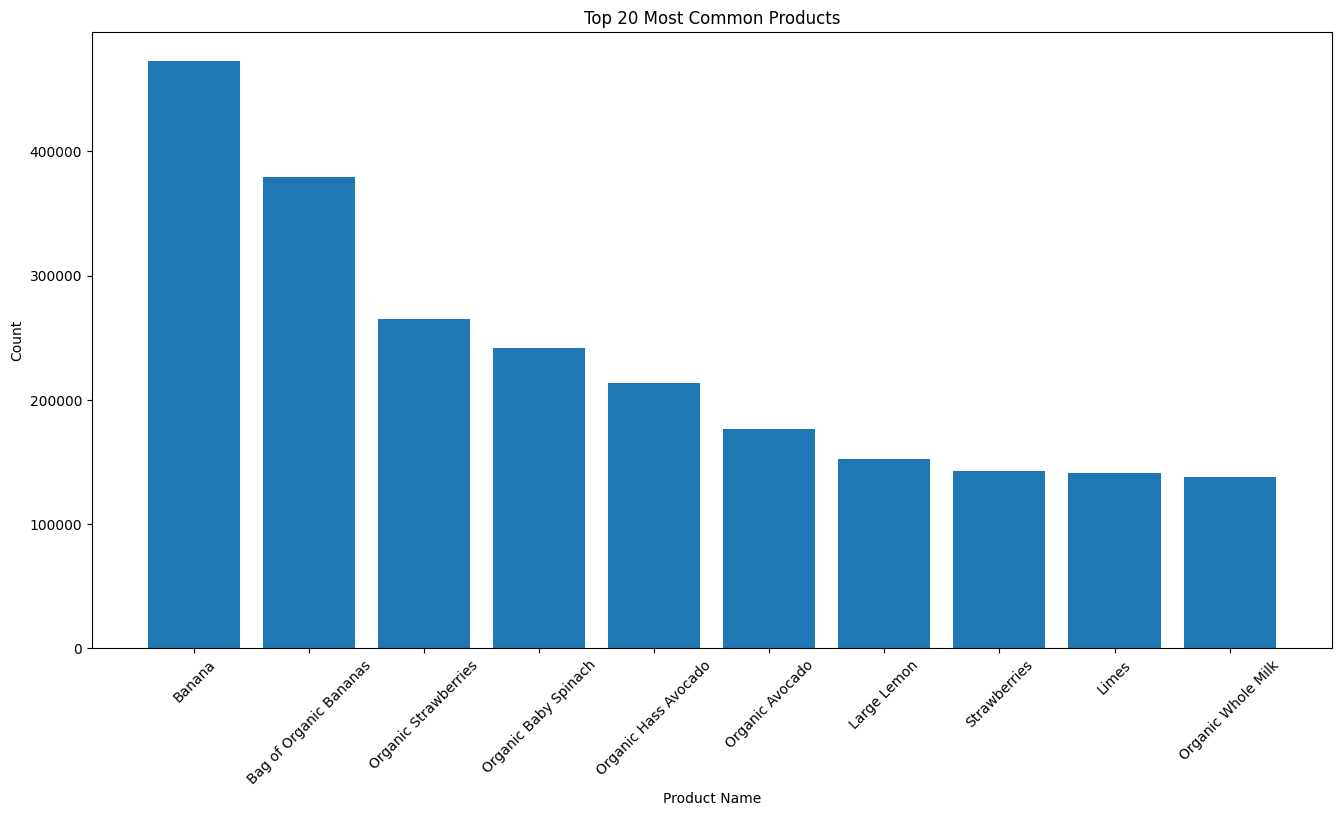

In [12]:
# Convert to Pandas for visualization
top_value_counts_pd = top_value_counts.toPandas()
# Plot a bar chart
plt.figure(figsize=(16, 8))
plt.bar(top_value_counts_pd['product_name'], top_value_counts_pd['count'])
plt.xlabel('Product Name')
plt.ylabel('Count')
plt.title('Top 20 Most Common Products')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Filter rows where product_name is null
null_values_df = df.filter(col("product_name").isNull())

# Count the number of null values
null_count = null_values_df.count()

if null_count > 0:
    print(f"The column 'product_name' has {null_count} null values.")
else:
    print("The column 'product_name' has no null values.")

The column 'product_name' has no null values.


In [14]:
ordered_products = df.select(df['product_name'], df['order_id'])
ordered_products.show(3)

+--------------------+--------+
|        product_name|order_id|
+--------------------+--------+
|  Organic Egg Whites|       2|
|Michigan Organic ...|       2|
|       Garlic Powder|       2|
+--------------------+--------+
only showing top 3 rows



In [15]:
ordered_products.printSchema()

root
 |-- product_name: string (nullable = true)
 |-- order_id: string (nullable = true)



In [16]:
# Group by 'order_id' and collect product names into a list
grouped_order_id = ordered_products.groupBy("order_id").agg(F.collect_set("product_name").alias("products"))


In [17]:
grouped_order_id.show(13)

+--------+--------------------+
|order_id|            products|
+--------+--------------------+
| 1000015|[Boneless Skinles...|
| 1000067|[Globe Eggplant, ...|
| 1000073|[Gluten Free Cinn...|
| 1000096|[Total 2% All Nat...|
|  100010|[Mocha Frappucino...|
| 1000113|[Fresh Asparagus,...|
| 1000128|[Homestyle Savory...|
| 1000131|[Wonderful 100% P...|
| 1000146|[Organic Bread wi...|
| 1000167|[Organic Green Ca...|
| 1000226|[Ezekiel 4:9 Brea...|
| 1000240|[Organic Baby Aru...|
| 1000280|[Total 0% Nonfat ...|
+--------+--------------------+
only showing top 13 rows



In [18]:
# Fetch the first row from the DataFrame
first_row = grouped_order_id.select(grouped_order_id.products).first()

# Print the value of the "products" column
print(first_row['products'])


['Boneless Skinless Chicken Breasts', 'Organic Zucchini', 'Unsweetened Organic Soy Milk', 'Organic Smoked Turkey Breast', 'Banana', 'Total 0% Nonfat Greek Yogurt', 'Original Crackers', 'Berry Medley', 'Swiss Cheese Deli Slices', 'Hot & Spicy Asian Soup', 'Organic Low Sodium Chicken Cooking Stock', 'Diet Ginger Ale All Natural Soda', 'Gluten Free Millet-Chia Bread', 'Dark Chocolate With Sea Salt & Almonds', 'Organic Sticks Low Moisture Part Skim Mozzarella String Cheese', 'Organic Uncured Sliced Black Forest Ham', 'Organic Small Bunch Celery']


In [19]:
grouped_order_id.select('order_id').distinct().count()

3214874

## Map Reduce

In [20]:
# Step 1: Define a UDF to generate triplets
#The generate_triplets function creates all possible combinations of 3 products from the products column.
def generate_triplets(products):
    if len(products) < 3:
        return []  # Ignore orders with fewer than 3 products
    return list(combinations(products, 3))

triplets_udf = udf(generate_triplets, ArrayType(ArrayType(StringType())))

In [21]:
# Step 2: Apply the UDF to create a column with triplets
#
# grouped_order_id_with_triplets = grouped_order_id.withColumn("triplets", triplets_udf(col("products")))

In [22]:
# Step 3: Explode triplets into separate rows
# explode(col("triplets")) flattens the array of triplets into individual rows, where each row represents one triplet.
# triplets_exploded = grouped_order_id_with_triplets.select(explode(col("triplets")).alias("triplet"))

In [23]:
# Step 4: Count occurrences of each triplet
# groups identical triplets and counts their occurrences across all orders.
# triplet_counts = triplets_exploded.groupBy("triplet").count()


In [24]:
# Step 5: Sort by count in descending order
# top_triplets = triplet_counts.orderBy(col("count").desc())


In [25]:
# Step 6: Get the top 3 triplets
# top_3_triplets = top_triplets.limit(3)

In [26]:
# Display the results
# top_3_triplets.show(truncate=False)

In [27]:
# top_3_triplets.write.csv("output/top_3_triplets.csv", header=True)


In [28]:
# from pyspark.sql.functions import concat_ws

# # Convert the array column "triplet" into a string column
# flattened_triplets = top_3_triplets.withColumn("triplet", concat_ws(",", "triplet"))

# # Save the result to a CSV file
# flattened_triplets.write.csv("output/top_3_triplets.csv", header=True)


In [29]:
# Split the array into separate columns
# split_triplets = top_3_triplets.selectExpr(
#     "triplet[0] as product1", 
#     "triplet[1] as product2", 
#     "triplet[2] as product3", 
#     "count"
# )

# Save to CSV
# split_triplets.write.csv("output/top_3_triplets.csv", header=True)
